## 15 Synthetic Control

- What if we have aggregated data that has only a few, we can do DID, but sample size is only 4 (same as the # of params).
|city|before|after|
|--|--|--|
|FL|171.64|206.16|
|POA|46.01|87.06|

- DID is $ (E[Y(1)|D=1] - E[Y(1)|D=0]) - (E[Y(0)|D=1] - E[Y(0)|D=0]) = (87.06 - 206.16) - (46.01 - 171.64) = 6.53 $
- The city may differ by its own fame such as FL has beautiful beaches/ POA has popular BBQ.
- Ex of cigars, higher tax may not decrease demand.
- 1988, CA passed proposition 99 - banning the ease of tabacco access.


In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline

pd.set_option("display.max_columns", 6)
style.use("fivethirtyeight")

In [5]:
data = {
    'Patient ID': [1, 2, 3, 4, 5],
    'Treatment Assignment': ['Treatment', 'Control', 'Treatment', 'Control', 'Treatment'],
    'Potential Outcome under Treatment (Y1)': [120, 140, 125, 130, 118],
    'Potential Outcome under Control (Y0)': [135, 140, 130, 130, 125],
    'Observed Outcome': [125, 140, 128, 130, 120]
}
df = pd.DataFrame(data)
df

,Patient ID,Treatment Assignment,Potential Outcome under Treatment (Y1),Potential Outcome under Control (Y0),Observed Outcome
0,1,Treatment,120,135,125
1,2,Control,140,140,140
2,3,Treatment,125,130,128
3,4,Control,130,130,130
4,5,Treatment,118,125,120


In [2]:
cigar_df = pd.read_csv('smoking.csv')
cigar_df

,state,year,cigsale,...,retprice,california,after_treatment
0,1,1970,89.800003,...,39.599998,False,False
1,1,1971,95.400002,...,42.700001,False,False
2,1,1972,101.099998,...,42.299999,False,False
3,1,1973,102.900002,...,42.099998,False,False
4,1,1974,108.199997,...,43.099998,False,False
...,...,...,...,...,...,...,...
1204,39,1996,110.300003,...,162.500000,False,True
1205,39,1997,108.800003,...,164.100006,False,True
1206,39,1998,102.900002,...,168.800003,False,True
1207,39,1999,104.800003,...,189.600006,False,True


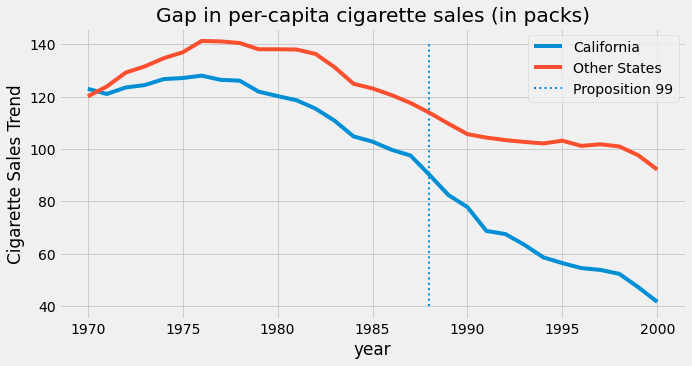

In [3]:
ax = plt.subplot(1, 1, 1)

(cigar_df
 .assign(california = np.where(cigar_df["california"], "California", "Other States"))
 .groupby(["year", "california"])
 ["cigsale"]
 .mean()
 .reset_index()
 .pivot("year", "california", "cigsale")
 .plot(ax=ax, figsize=(10,5)))

plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Cigarette Sales Trend")
plt.title("Gap in per-capita cigarette sales (in packs)")
plt.legend();  

- The graph looks that CA has lower sales than the other states. The effect seems CA is lower.
- But, we cannot say that it is lower and it is a guess through the plot.
- Fake state that is similar to the trend of CA.

### Time
$ \tau_{1t} $ (effect) $ = Y^I_{1t}$ (potential outcome w/o intervention, factual) $ - Y^N_{1t} $ (potential outcome w/ intervention, counterfactual) 

- If California is $ Y^I_{jt} $, $ Y^N_{jt} $ is fake california that has the same trend before the intervention. The difference between fake-ca and ca after intervention is $ \tau_{1t} $

- Units from 2 to J+1 are other states (Not treated) and CA's unit is 1 (Treated)
- j = 2,...,J+1 untreated units (donor pool)
- T_0 before event
- t time

- $ \hat{Y}^N_{1t} = \sum^{J+1}_{j=2} w_j Y_{jt} $ where $W = (W_2,  ..., W_{J+1})$

In [4]:
features = ["cigsale", "retprice"]

inverted = (cigar_df.query("~after_treatment") # filter pre-intervention period
            .pivot(index='state', columns="year")[features] # make one column per year and one row per state
            .T) # flip the table to have one column per state

inverted.head()

state                 1           2           3   ...          37          38  \
        year                                      ...                           
cigsale 1970   89.800003  100.300003  123.000000  ...  114.500000  106.400002   
        1971   95.400002  104.099998  121.000000  ...  111.500000  105.400002   
        1972  101.099998  103.900002  123.500000  ...  117.500000  108.800003   
        1973  102.900002  108.000000  124.400002  ...  116.599998  109.500000   
        1974  108.199997  109.699997  126.699997  ...  119.900002  111.800003   

state                 39  
        year              
cigsale 1970  132.199997  
        1971  131.699997  
        1972  140.000000  
        1973  141.199997  
        1974  145.800003  

[5 rows x 39 columns]

In [5]:
y = inverted[3].values # state of california
X = inverted.drop(columns=3).values  # other states

In [6]:
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression(fit_intercept=False).fit(X, y).coef_
weights_lr.round(3)

array([-0.436, -1.038,  0.679,  0.078,  0.339,  1.213,  0.143,  0.555,
       -0.295,  0.052, -0.529,  1.235, -0.549,  0.437, -0.023, -0.266,
       -0.25 , -0.667, -0.106, -0.145,  0.109,  0.242, -0.328,  0.594,
        0.243, -0.171, -0.02 ,  0.14 , -0.811,  0.362,  0.519, -0.304,
        0.805, -0.318, -1.246,  0.773, -0.055, -0.032])

In [7]:
len(weights_lr)

38

In [8]:
calif_synth_lr = (cigar_df.query("~california")
                  .pivot(index='year', columns="state")["cigsale"]
                  .values.dot(weights_lr))

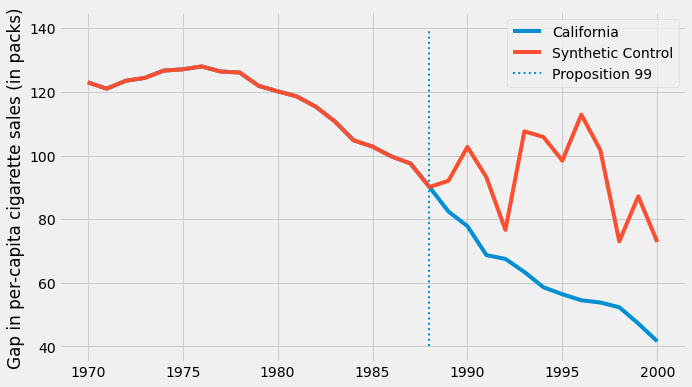

In [9]:
plt.figure(figsize=(10,6))
plt.plot(cigar_df.query("california")["year"], cigar_df.query("california")["cigsale"], label="California")
plt.plot(cigar_df.query("california")["year"], calif_synth_lr, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend();

## Extrapolation and Interpolation
- Extrapolation is having one weight per unit which causes multiple units and might overfit.
- Interpolation is constraining by making many units' weights into 0 and the sum of unit weights into 1.

- This is to minimize
$
||\pmb{X}_1 - \pmb{X}_0 \pmb{W}|| = \bigg(\sum^k_{h=1}v_h \bigg(X_{h1} - \sum^{J+1}_{j=2} w_j X_{hj} \bigg)^2 \bigg)^{\frac{1}{2}}
$


In [10]:
from typing import List
from operator import add
from toolz import reduce, partial

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

In [11]:
lambda x: np.sum(x) - 1

<function __main__.<lambda>(x)>

In [12]:
from scipy.optimize import fmin_slsqp

def get_w(X, y):
    
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

In [13]:
calif_weights = get_w(X, y)
print("Sum:", calif_weights.sum())
np.round(calif_weights, 4)

Sum: 1.000000000000236


array([0.    , 0.    , 0.    , 0.0852, 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.113 , 0.1051, 0.4566, 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.2401, 0.    , 0.    , 0.    , 0.    , 0.    ])

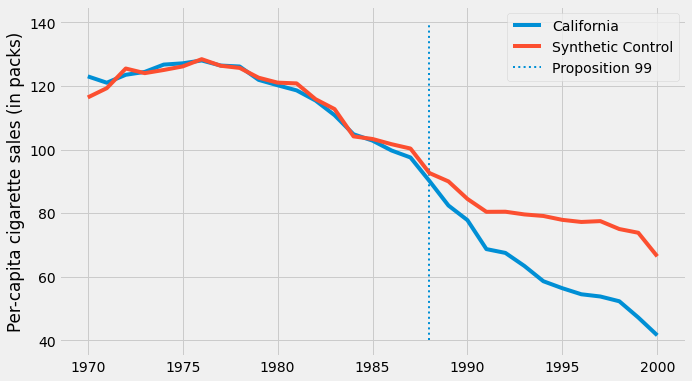

In [17]:
calif_synth = cigar_df.query("~california").pivot(index='year', columns="state")["cigsale"].values.dot(calif_weights)
plt.figure(figsize=(10,6))
plt.plot(cigar_df.query("california")["year"], cigar_df.query("california")["cigsale"], label="California")
plt.plot(cigar_df.query("california")["year"], calif_synth, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Per-capita cigarette sales (in packs)")
plt.legend();

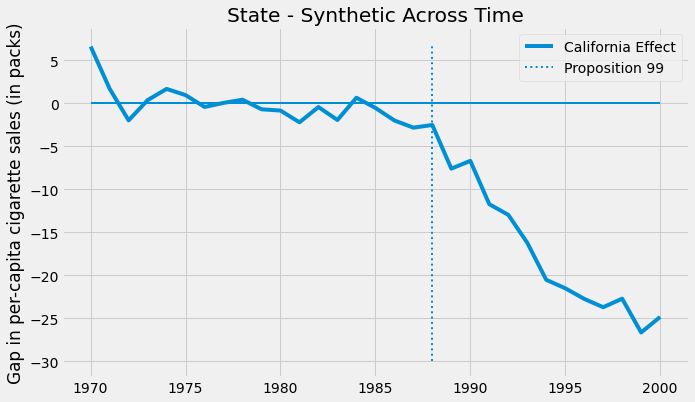

In [18]:
plt.figure(figsize=(10,6))
plt.plot(cigar_df.query("california")["year"], cigar_df.query("california")["cigsale"] - calif_synth,
         label="California Effect")
plt.vlines(x=1988, ymin=-30, ymax=7, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=2)
plt.title("State - Synthetic Across Time")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend();

- -25 effect at 20, good result,
- But is it statistically significant?

In [19]:
def synthetic_control(state: int, data: pd.DataFrame) -> np.array:
    
    features = ["cigsale", "retprice"]
    
    inverted = (data.query("~after_treatment")
                .pivot(index='state', columns="year")[features]
                .T)
    
    y = inverted[state].values # treated
    X = inverted.drop(columns=state).values # donor pool

    weights = get_w(X, y)
    synthetic = (data.query(f"~(state=={state})")
                 .pivot(index='year', columns="state")["cigsale"]
                 .values.dot(weights))

    return (data
            .query(f"state=={state}")[["state", "year", "cigsale", "after_treatment"]]
            .assign(synthetic=synthetic))

In [20]:
synthetic_control(1, cigar_df).head()

,state,year,cigsale,after_treatment,synthetic
0,1,1970,89.800003,False,95.029419
1,1,1971,95.400002,False,99.118199
2,1,1972,101.099998,False,101.881329
3,1,1973,102.900002,False,103.938655
4,1,1974,108.199997,False,107.038473


In [22]:
from joblib import Parallel, delayed

control_pool = cigar_df["state"].unique()

parallel_fn = delayed(partial(synthetic_control, data=cigar_df))

synthetic_states = Parallel(n_jobs=8)(parallel_fn(state) for state in control_pool)

In [23]:
synthetic_states[0].head()

,state,year,cigsale,after_treatment,synthetic
0,1,1970,89.800003,False,95.029419
1,1,1971,95.400002,False,99.118199
2,1,1972,101.099998,False,101.881329
3,1,1973,102.900002,False,103.938655
4,1,1974,108.199997,False,107.038473


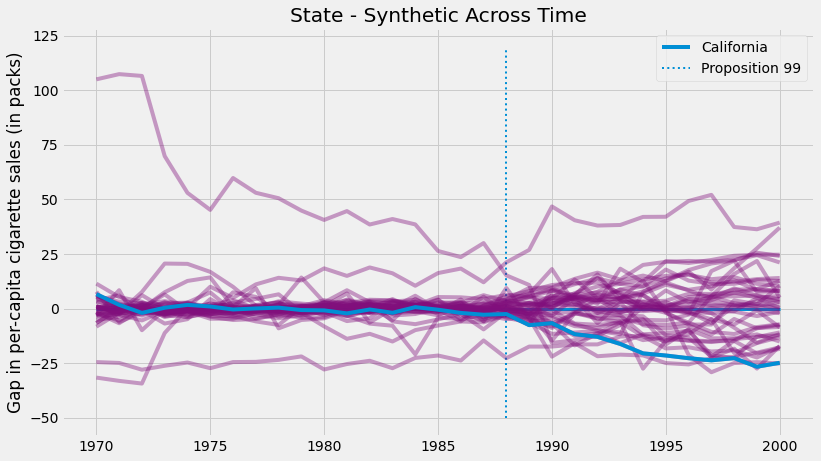

In [25]:
plt.figure(figsize=(12,7))
for state in synthetic_states:
    plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5",alpha=0.4)

plt.plot(cigar_df.query("california")["year"], cigar_df.query("california")["cigsale"] - calif_synth,
        label="California");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("State - Synthetic Across Time")
plt.legend();

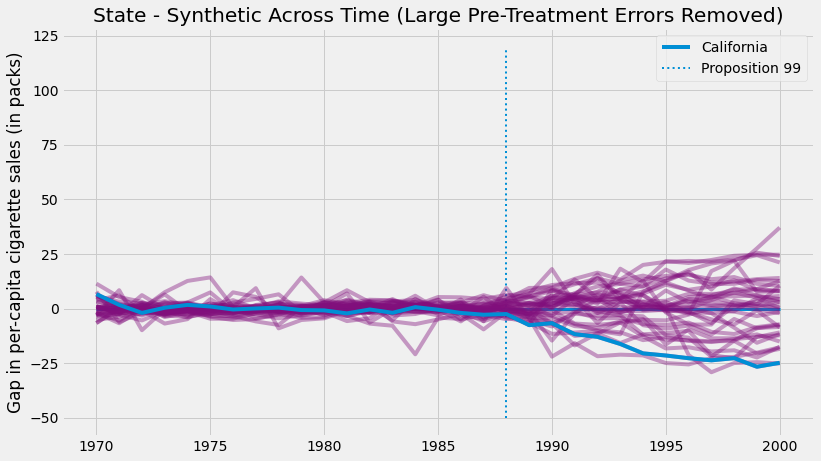

In [26]:
def pre_treatment_error(state):
    pre_treat_error = (state.query("~after_treatment")["cigsale"] 
                       - state.query("~after_treatment")["synthetic"]) ** 2
    return pre_treat_error.mean()

plt.figure(figsize=(12,7))
for state in synthetic_states:
    
    # remove units with mean error above 80.
    if pre_treatment_error(state) < 80:
        plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5",alpha=0.4)

plt.plot(cigar_df.query("california")["year"], cigar_df.query("california")["cigsale"] - calif_synth,
        label="California");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("Distribution of Effects")
plt.title("State - Synthetic Across Time (Large Pre-Treatment Errors Removed)")
plt.legend();


In [29]:
calif_number = 3

effects = [state.query("year==2000").iloc[0]["cigsale"] - state.query("year==2000").iloc[0]["synthetic"]
           for state in synthetic_states
           if pre_treatment_error(state) < 80] # filter out noise

calif_effect = cigar_df.query("california & year==2000").iloc[0]["cigsale"] - calif_synth[-1] 

print("California Treatment Effect for the Year 2000:", calif_effect)
np.array(effects)

California Treatment Effect for the Year 2000: -24.830159744091695


array([  5.79715887,   0.8945899 , -24.83015974,  -7.16628123,
       -10.92204859,  37.11640554, -15.06971705,  -0.49805125,
       -18.45795056,  21.13366449,  12.57782758,  -1.47547828,
        10.49627385, -11.67012334,   4.29850825,   8.04811409,
        14.0232241 ,   8.25002726,   0.32576356,  -8.40826864,
        -2.12402708,  -7.42865049,   2.96157493,  24.10478122,
         4.25211769, -17.75844573,   7.93334015,   2.81640125,
        12.64955948, -17.47677513, -25.16040944, -12.26469128,
        24.69067344,  10.3629958 ,  -8.59880378])

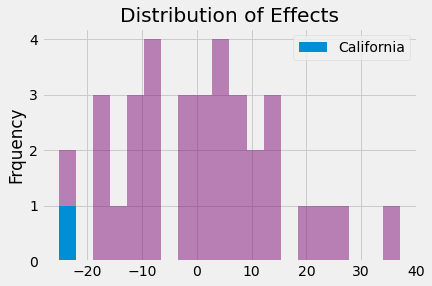

In [30]:
_, bins, _ = plt.hist(effects, bins=20, color="C5", alpha=0.5);
plt.hist([calif_effect], bins=bins, color="C0", label="California")
plt.ylabel("Frquency")
plt.title("Distribution of Effects")
plt.legend();

$ PV=\frac{1}{N}\sum \mathcal{1}\{\hat{\tau}_{Calif} > \hat{\tau}_j\} $
- This is the estimated P-value as the proportion of times

In [31]:
np.mean(np.array(effects) < calif_effect)

0.02857142857142857